# MNIST Example with Data Parallelism
In this notebook we provide a simple exmple of using scalax `sjit` to train models on multiple accelerators with data parallelism. We use the MNIST dataset and train a simple MLP (multi-layered percepttron) model implemented in flax. We show that scalax makes it simple to convert single GPU code to run on multiple accelerators.

In [16]:
from functools import partial

import jax
import jax.numpy as jnp

import flax
from flax import linen as nn
from flax.training.train_state import TrainState
import optax

import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm, trange

import torch
import torchvision

from scalax.utils import JaxRNG
from scalax.sharding import PartitionSpec, MeshShardingHelper

%matplotlib inline

JaxRNG.init_global_rng(42)

## MLP model definition
In this section we define a simple 4-layer MLP model with 4096 hidden units.

In [12]:
class MLP(nn.Module):
    output_dim: int

    @nn.compact
    def __call__(self, x):
        for _ in range(4):
            x = nn.Dense(4096)(x)
            x = nn.relu(x)
        output = nn.Dense(self.output_dim)(x)
        return output


model = MLP(10)

## Dataset and DataLoader
We use the torchvision and pytorch dataloader to download and load the MNIST
dataset

In [13]:
dataset = torchvision.datasets.MNIST(
    '/tmp/torch_data', train=True, download=True,
    transform=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        (0.1307,), (0.3081,))
    ])
)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1024, num_workers=8)

## Sharded Train Step
We define the train step and shard it with the `sjit` method of `MeshShardingHelper` to implement data parallelism. In data parallelism, the model is replicated, and the data is sharded along the batch axis. We can simply specify this as arugments to `sjit`, without changing the `train_step` function. The `train_step` here is exactly the same as if we are training on a single GPU.

In [17]:
# Create a 1D mesh with axis name `data`
mesh = MeshShardingHelper(axis_dims=[-1], axis_names=['data'])

@partial(
    mesh.sjit,
    in_shardings=None, # Model and data are replicated in the input
    out_shardings=None, # Model and metrics are replicated in the output
    # Inside the function, the data should be sharded according to the `data` axis
    args_sharding_constraint=(None, PartitionSpec('data'), PartitionSpec('data')),
) 
def train_step(train_state, x, y): # The train staep function is the same as for a single GPU
    @partial(jax.value_and_grad, has_aux=True)
    def grad_fn(params):
        logits = model.apply(params, x)
        one_hot = jax.nn.one_hot(y, 10, dtype=jnp.float32)
        log_prob = jax.nn.log_softmax(logits)
        loss = -jnp.mean(log_prob * one_hot)
        accuracy = (jnp.argmax(logits, axis=-1) == y).astype(jnp.float32).mean()
        return loss, accuracy

    (loss, accuracy), grads = grad_fn(train_state.params)
    train_state = train_state.apply_gradients(grads=grads)
    return train_state, loss, accuracy


params = model.init(JaxRNG.next_rng(), jnp.zeros((10, 28*28)))
optimizer = optax.sgd(0.01, 0.1)

train_state = TrainState.create(
    params=params, tx=optimizer,
    apply_fn=None
)

## Running the Sharded Train Step
Now let's run the sharded train step

  0%|          | 0/10 [00:00<?, ?it/s]

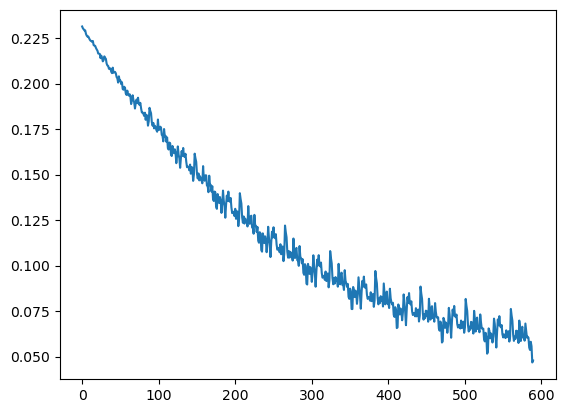

In [18]:
losses = []
accuracies = []
for epoch in trange(10):
    for x, y in dataloader:
        x = x.reshape(-1, 28 * 28).numpy()
        y = y.numpy()
        train_state, loss, accuracy = train_step(train_state, x, y)
        losses.append(loss.item())
        accuracies.append(accuracy.item())


plt.plot(losses)